In [104]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


# load data and do exploratory data analysis. One hot encode categorical features

df = pd.read_csv("PeerLoanKart_fraud.csv")

df.rename(columns={"Loan Repayment Status": "target"}, inplace=True)
df["target"] = (df["target"]!="Paid")*1
df = pd.concat((df, pd.get_dummies(df["purpose"], dtype="int")), axis=1)

# Select data and target

features = ['credit_card',
            'debt_consolidation',
            'educational',
            'home_improvement',
            'major_purchase',
            'small_business',
            'log.annual.inc',
            'fico',
            'delinq.2yrs',
            'pub.rec',
            'credit.policy',
            'int.rate',
            'installment',
            'days.with.cr.line',
            'inq.last.6mths',
            'dti',
            'revol.util',
            'revol.bal',
          ]

target = ['target']

X = df[features + target]

In [105]:
# General statistics of input variables
X.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
credit_card,9578.0,0.131760,0.338248,0.000000,0.000000,0.000000,0.000000,1.000000e+00
debt_consolidation,9578.0,0.413134,0.492422,0.000000,0.000000,0.000000,1.000000,1.000000e+00
educational,9578.0,0.035811,0.185829,0.000000,0.000000,0.000000,0.000000,1.000000e+00
home_improvement,9578.0,0.065671,0.247720,0.000000,0.000000,0.000000,0.000000,1.000000e+00
major_purchase,9578.0,0.045625,0.208682,0.000000,0.000000,0.000000,0.000000,1.000000e+00
small_business,9578.0,0.064627,0.245880,0.000000,0.000000,0.000000,0.000000,1.000000e+00
log.annual.inc,9578.0,10.932117,0.614813,7.547502,10.558414,10.928884,11.291293,1.452835e+01
fico,9578.0,710.846314,37.970537,612.000000,682.000000,707.000000,737.000000,8.270000e+02
delinq.2yrs,9578.0,0.163708,0.546215,0.000000,0.000000,0.000000,0.000000,1.300000e+01
pub.rec,9578.0,0.062122,0.262126,0.000000,0.000000,0.000000,0.000000,5.000000e+00


In [106]:
# Checking if any of the fields have nulls and need to be filled in
X.isnull().sum()/X.shape[0]

credit_card           0.0
debt_consolidation    0.0
educational           0.0
home_improvement      0.0
major_purchase        0.0
small_business        0.0
log.annual.inc        0.0
fico                  0.0
delinq.2yrs           0.0
pub.rec               0.0
credit.policy         0.0
int.rate              0.0
installment           0.0
days.with.cr.line     0.0
inq.last.6mths        0.0
dti                   0.0
revol.util            0.0
revol.bal             0.0
target                0.0
dtype: float64

In [109]:
# Positive/Negative probability distribution functions per variable.
# If the two probabilty distributions are seperate enough then this is a good input variable to use.

def pdf(X, var):
    X_pos = X[X["target"]==1]
    X_neg = X[X["target"]==0]
    ax = X_pos[var].hist(density=True, color="red", alpha=0.3)
    X_neg[var].hist(ax=ax, density=True, color="blue", alpha=0.3)
    plt.xlabel(var)
    plt.ylabel("Percentage")
    plt.title("Probability Distribution Function")
    plt.legend(["target=1", "target=0"])
    plt.plot()

# Weight of evidence plots. The weight of evidence is essentially just Log of percentage of negatives divided by percentage of positives
# per quantile bin of the input variable. A Linear WoE indicated that the variable scales with the target

def woe(X, var, Nq):
    varq = var + "_q"
    X_copy = X[[var, "target"]].copy(deep=True)
    X_copy = pd.concat((X_copy, pd.qcut(X_copy[var], Nq).map(lambda x: x.left).rename(varq) ), axis=1)
    Xg = X_copy[[varq, "target"]].groupby([varq, "target"]).size().unstack(-1)
    Xg_norm = Xg/Xg.sum()
    Xg_norm["WoE"] = -np.log(Xg_norm[0]/Xg_norm[1])
    Xg_norm["WoE"].plot()
    plt.xlabel(var + " quantile bins")
    plt.ylabel("WoE")
    plt.title("Weight of Evidence")
    plt.plot()

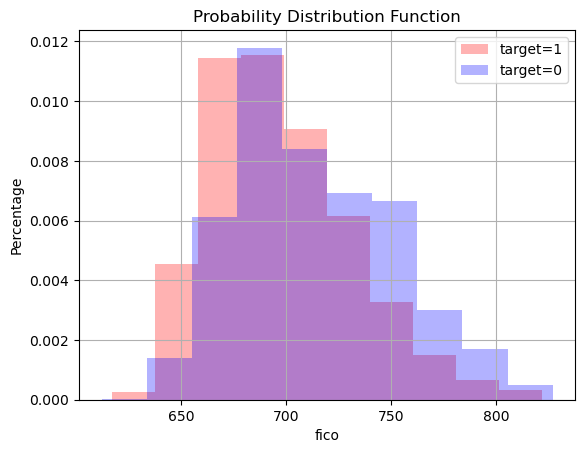

/var/folders/0k/83l_5vx90t5582c6lxpd87cm0000gn/T/ipykernel_12425/3475462905.py:22: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  Xg = X_copy[[varq, "target"]].groupby([varq, "target"]).size().unstack(-1)


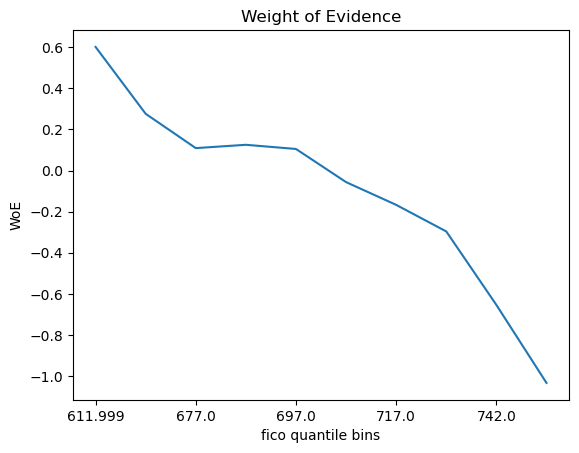

In [110]:
## FICO

feature = "fico"
pdf(X, feature)
plt.show()
x = woe(X, feature, 10)
plt.show()

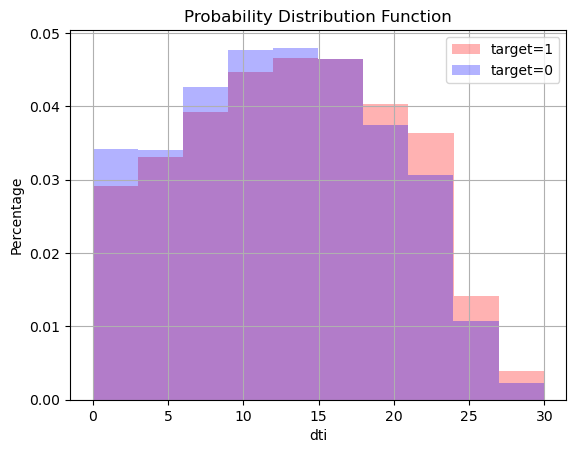

/var/folders/0k/83l_5vx90t5582c6lxpd87cm0000gn/T/ipykernel_12425/3475462905.py:22: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  Xg = X_copy[[varq, "target"]].groupby([varq, "target"]).size().unstack(-1)


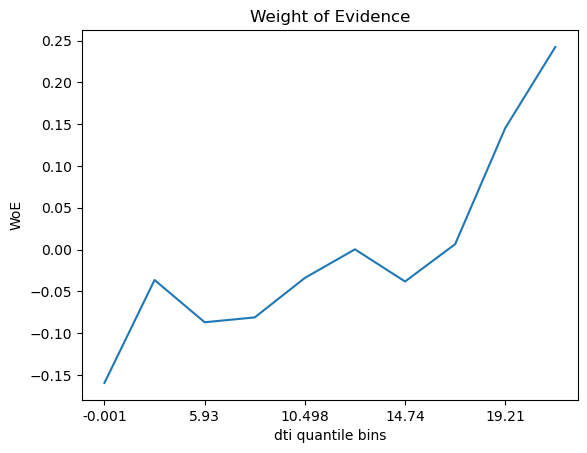

In [111]:
## Debt to Income

feature = "dti"
pdf(X, feature)
plt.show()
woe(X, feature, 10)
plt.show()

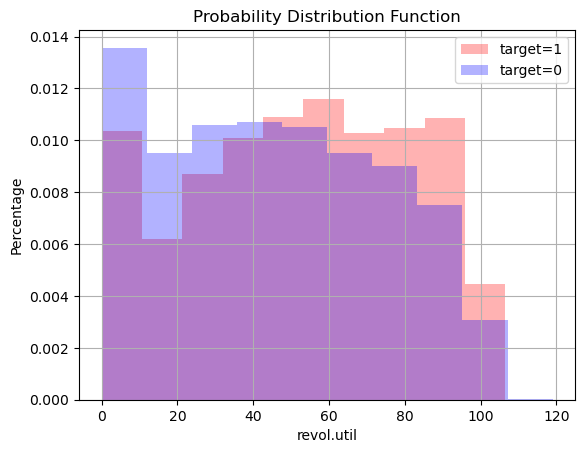

/var/folders/0k/83l_5vx90t5582c6lxpd87cm0000gn/T/ipykernel_12425/3475462905.py:22: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  Xg = X_copy[[varq, "target"]].groupby([varq, "target"]).size().unstack(-1)


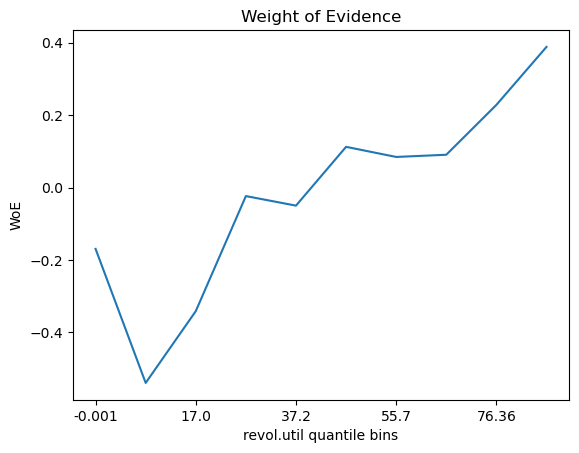

In [112]:
## Percentage of balance utilized

feature = "revol.util"
pdf(X, feature)
plt.show()
woe(X, feature, 10)
plt.show()

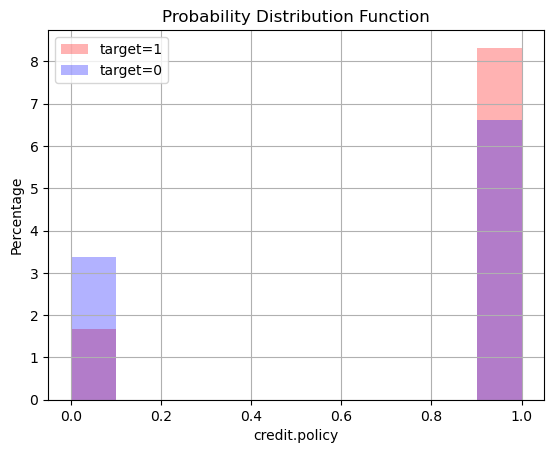

In [101]:
## Peer Loan Kart credit underwriting criteria

feature = "credit.policy"
pdf(X, feature)
plt.show()

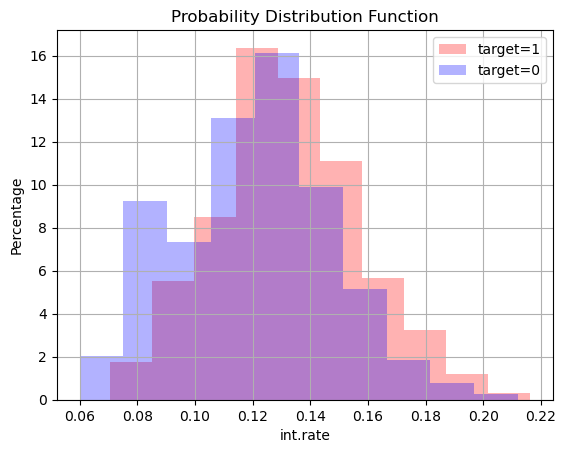

/var/folders/0k/83l_5vx90t5582c6lxpd87cm0000gn/T/ipykernel_12425/3475462905.py:22: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  Xg = X_copy[[varq, "target"]].groupby([varq, "target"]).size().unstack(-1)


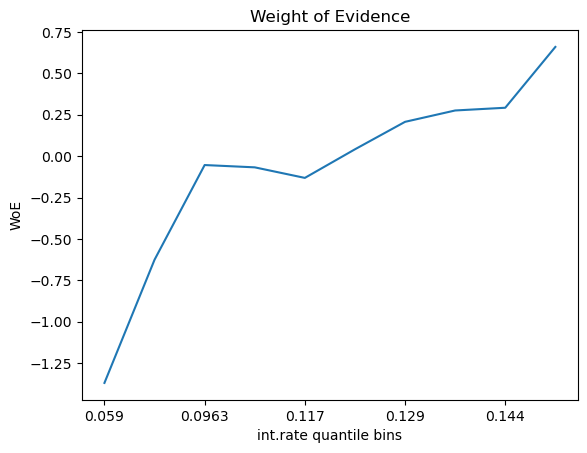

In [113]:
## Interest Rate

feature = "int.rate"
pdf(X, feature)
plt.show()
woe(X, feature, 10)
plt.show()